# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here
%matplotlib inline
import matplotlib as plt
import seaborn as sb

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision as tv
#from torchvision import datasets
#from torchvision import transforms
#from torchvision import models

import time
import json

from random import randint 

from PIL import Image

from collections import OrderedDict

#COOKBOOK:
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [4]:
#time.struct_time(tm_year=2018, tm_mon=10, tm_mday=17, tm_hour=10, tm_min=2, tm_sec=15, tm_wday=2, tm_yday=290, tm_isdst=0)
def get_time_string():
    return time.strftime('%Y%m%d%H%M%S')

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = r'./flowers'
train_dir = data_dir + r'/train'
valid_dir = data_dir + r'/valid'
test_dir = data_dir + r'/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets

#Actually the .Normalize parameters are from:
#https://pytorch.org/docs/master/torchvision/models.html
train_transforms = tv.transforms.Compose([tv.transforms.RandomHorizontalFlip(),
                                          tv.transforms.RandomVerticalFlip(),
                                          tv.transforms.RandomRotation(30),
                                          tv.transforms.RandomCrop(500),
                                          tv.transforms.Resize(224),
                                          tv.transforms.ToTensor(),
                                          tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

valid_transforms = tv.transforms.Compose([tv.transforms.CenterCrop(500),
                                          tv.transforms.Resize(224),
                                          tv.transforms.ToTensor(),
                                          tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

test_transforms = tv.transforms.Compose([tv.transforms.CenterCrop(500),
                                         tv.transforms.Resize(224),
                                         tv.transforms.ToTensor(),
                                         tv.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_dataset = tv.datasets.ImageFolder(root = train_dir, transform = train_transforms)
valid_dataset = tv.datasets.ImageFolder(root = valid_dir, transform = valid_transforms)
test_dataset = tv.datasets.ImageFolder(root = test_dir, transform = test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True) #, num_workers=2)
dataloader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=16)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=16) 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# cat_to_name is a dictionary, examples:
#'21': 'fire lily',
#'3': 'canterbury bells',

### Having a look at some images now (Ferenc)
Show 9 samples to be sure there is **no garbage loaded**

0 torch.Size([3, 224, 224]) 43 wallflower


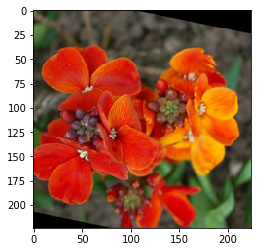

1 torch.Size([3, 224, 224]) 93 hippeastrum


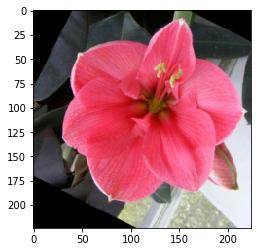

2 torch.Size([3, 224, 224]) 78 lotus lotus


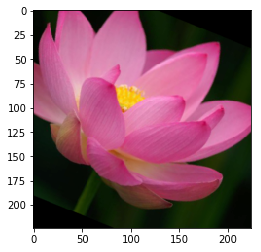

3 torch.Size([3, 224, 224]) 77 passion flower


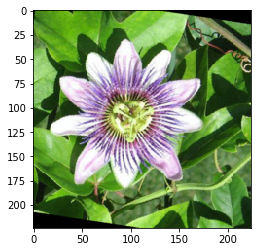

4 torch.Size([3, 224, 224]) 96 foxglove


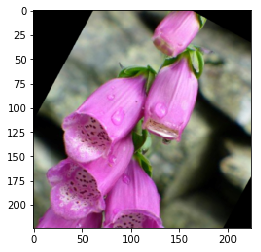

5 torch.Size([3, 224, 224]) 73 water lily


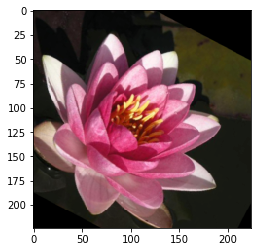

6 torch.Size([3, 224, 224]) 1 globe thistle


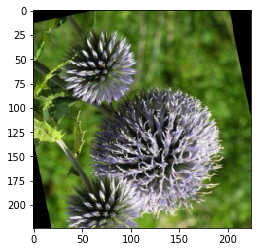

7 torch.Size([3, 224, 224]) 75 thorn apple


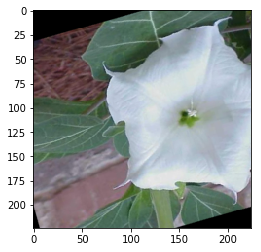

8 torch.Size([3, 224, 224]) 25 canterbury bells


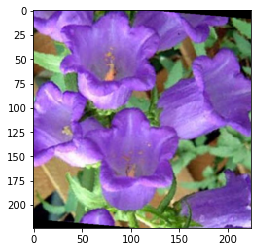

9 torch.Size([3, 224, 224]) 74 rose


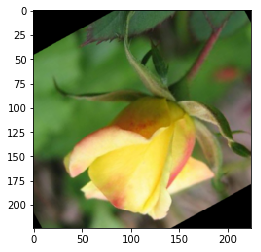

10 torch.Size([3, 224, 224]) 86 desert-rose


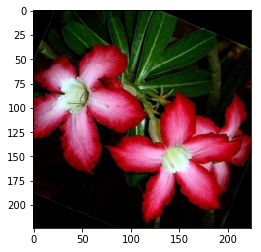

11 torch.Size([3, 224, 224]) 92 canna lily


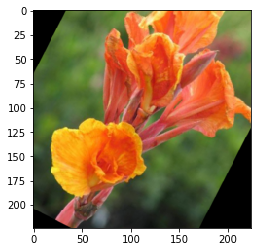

12 torch.Size([3, 224, 224]) 47 english marigold


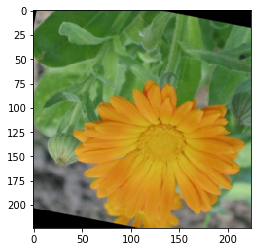

13 torch.Size([3, 224, 224]) 53 pelargonium


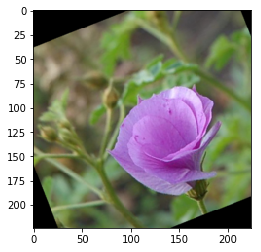

14 torch.Size([3, 224, 224]) 92 canna lily


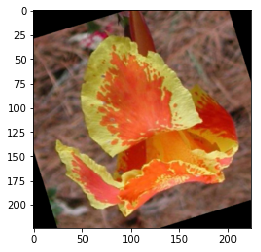

15 torch.Size([3, 224, 224]) 46 oxeye daisy


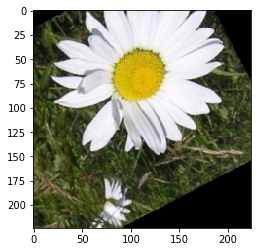

16 torch.Size([3, 224, 224]) 44 marigold


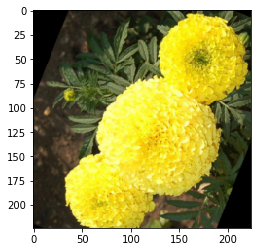

17 torch.Size([3, 224, 224]) 66 spring crocus


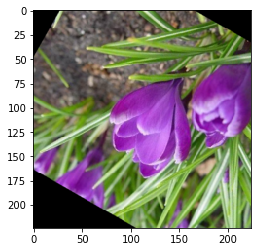

18 torch.Size([3, 224, 224]) 97 bougainvillea


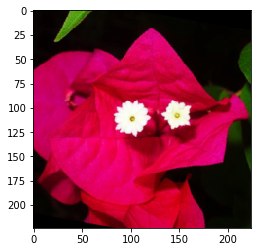

19 torch.Size([3, 224, 224]) 64 californian poppy


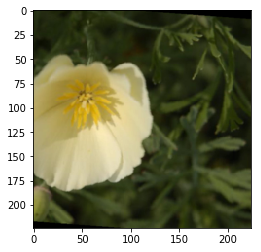

In [6]:
#Inspired by
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#print(train_dataset.classes)
length_of_dataset = len(train_dataset)

#Display dimension information for the pictures
#dim1, dim2 = [], []
#for mycnt in range(length_of_dataset):
#    sample = train_dataset[mycnt]
#    dim1.append(sample[0].size()[1])
#    dim2.append(sample[0].size()[2])
#print ('Image dimension mean and min: ', np.mean(dim1), np.mean(dim2), np.min(dim1), np.min(dim2))
    
#Display 20 random samples
for mycnt in range(20):
    #sample = train_dataset[mycnt]
    sample = train_dataset[randint(0, length_of_dataset-1)]
    print(mycnt, str(sample[0].size()), sample[1], cat_to_name.get(train_dataset.classes[sample[1]]))
    
    #Basically copy & paste from:
    #def imshow(image, ax=None, title=None):
    image = sample[0].numpy().transpose((1, 2, 0))
    image = np.array([0.229, 0.224, 0.225]) * image + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    plt.pyplot.imshow(image)
    plt.pyplot.show()
         
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
#Define my model
model = tv.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
#Getting the number of features for the classifier
num_ftrs = model.classifier[0].in_features
print(num_ftrs)


#Freeze all model parameters
for param in model.parameters():
    param.requires_grad=False

classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(num_ftrs, 4096, bias = True)),
                ('relu', nn.ReLU()),
                ('drop', nn.Dropout(p=0.2)),
                ('fc2', nn.Linear(4096, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))

model.classifier = classifier

#MOVE model to CUDA!!!!
#This also makes associated parameters and buffers different objects. 
#So it should be called before constructing optimizer if the module will live on GPU while being optimized.
#https://pytorch.org/docs/stable/nn.html?highlight=cuda#torch.nn.Module.cuda
model.cuda()

25088


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
#Define my criterion and optimizers

#MOVE MODEL TO CUDA FIRST!!!! SEE: https://pytorch.org/docs/stable/optim.html
#Define my criterion and loss_function
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.classifier.parameters(), 0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer.zero_grad()

#optimizer = torch.optim.RMSprop(model.classifier.parameters(), lr=0.01, alpha=0.99, eps=1e-08, 
#                                weight_decay=0, momentum=0, centered=False)

#def oneepoch(trainloader):


In [10]:
#Train my model

model.train()

print(get_time_string(), 'TRAINING IS STARTING !!!')

for epc in range(20):
    print(get_time_string(), 'Now training EPOCH #', epc+1)
    cnt = 0
    loss_list = []
    for cnt, (myinput, mytarget) in enumerate(dataloader_train):
        mytarget = mytarget.cuda()
        myinput = myinput.cuda()
        optimizer.zero_grad()
    
        #input_tmp = torch.autograd.Variable(myinput)
        #target_tmp = torch.autograd.Variable(mytarget)
    
        myoutput = model(myinput)
        loss = criterion(myoutput, mytarget)

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        if cnt % 100 == 0:
            print(cnt, np.mean(loss_list))            

print(get_time_string(), 'TRAINING IS FINISHED !!!')

20190512170051 TRAINING IS STARTING !!!
20190512170051 Now training EPOCH # 1
0 4.648510932922363
100 4.772818999715371
200 3.3455372853065604
300 2.7473214054820545
400 2.4129328085597317
20190512170308 Now training EPOCH # 2
0 1.0447598695755005
100 0.9685354296228673
200 1.0173398254077826
300 1.005157465158507
400 0.9988289581718588
20190512170524 Now training EPOCH # 3
0 0.5643602609634399
100 0.8050078488517516
200 0.8269810980528741
300 0.8288067413920976
400 0.8395777214829464
20190512170739 Now training EPOCH # 4
0 1.2517322301864624
100 0.6483163871239908
200 0.7062613185476604
300 0.7198876682730806
400 0.7168669432954412
20190512170954 Now training EPOCH # 5
0 0.4921397864818573
100 0.6791991154008573
200 0.685484762196962
300 0.719024289387009
400 0.7216468507475092
20190512171208 Now training EPOCH # 6
0 0.47819727659225464
100 0.5943347537097069
200 0.6426156416479776
300 0.6964789510107416
400 0.7138040884818296
20190512171423 Now training EPOCH # 7
0 0.8244076371192932

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# TODO: Do validation on the test set
#import csv #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!!

#Code from image classifier solution used here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#https://automatetheboringstuff.com/chapter14/
#outputFile = open('./' + get_time_string() + '-debug_save.csv', 'w', newline='') #DEBUG!!! DEBUG!!! DEBUG!!!
#outputWriter = csv.writer(outputFile) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!!

#my_debug = np.empty((16,1)) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! 

print(get_time_string(), 'VALIDATION IS STARTING !!!')

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for(images, labels) in dataloader_test: #dataloader_test:  #dataloader_valid:
        images = images.cuda() 
        labels = labels.cuda()
        outputs = model(images)
        #outputWriter.writerow(outputs.data.cpu().numpy().tostring()) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! 
        _, predicted = torch.max(outputs.data, 1)
        #print(lambda i: True if i else False)(labels.cpu().numpy() == predicted.cpu().numpy()) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!!
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on 819 test images: %d %%' % (100 * correct / total))
#np.savetxt(, my_debug) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!!
print(get_time_string(), 'VALIDATION IS FINISHED !!!')
#outputFile.close() #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!!



20190512174547 VALIDATION IS STARTING !!!
Accuracy of the network on 819 test images: 83 %
20190512174559 VALIDATION IS FINISHED !!!


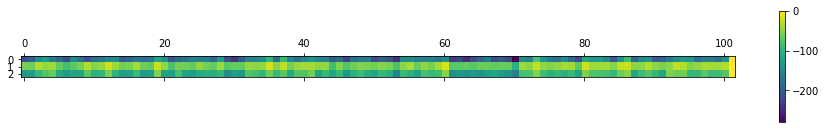

In [13]:
plt.pyplot.matshow(outputs)
plt.pyplot.colorbar()

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# TODO: Save the checkpoint 
#https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
#https://pytorch.org/tutorials/beginner/saving_loading_models.html

def save_net():
    state = {
        'epoch': epc,
        #'input_size' : 25088,
        #'output_size' : 102,
        #'hidden_layers' : [each.parameters for each in model.features],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        #'classifier' : model.classifier.state_dict()
    }
    torch.save(state, './' + get_time_string() + '-vgg16_save.pth')

In [15]:
save_net()

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [8]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
#https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4

#Great! :-( There seems to be an 'Out of Memory' Issue with loaded models. 
#So I have to decrase the batch size from 32 to 1 for training, otherwise OUT OF GPU MEMORY!
#(181018) Decreased batch size to 1, no effect - Can load only on Udacity cloud, there 16 batch no problem. 
#https://github.com/pytorch/fairseq/issues/51

def load_net(filepath):
    checkpoint = torch.load(filepath) #G:\Udacity_Save\
    
    #new_state_dict = OrderedDict()
    #for k, v in checkpoint['model_state_dict'].items():
    #    name = k[7:] # remove module.
    #    new_state_dict[name] = v
    
    my_model = tv.models.vgg16(pretrained = True)
    num_ftrs = my_model.classifier[0].in_features

    #Freeze all model parameters
    for param in my_model.parameters():
        param.requires_grad=False

    #my_model = my_model.cuda()

    classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(num_ftrs, 4096, bias = True)),
                ('relu', nn.ReLU()),
                ('drop', nn.Dropout(p=0.2)),
                ('fc2', nn.Linear(4096, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))
    
    my_model.classifier = classifier
    my_model.load_state_dict(checkpoint['model_state_dict'])
    my_model = my_model.cuda()
    my_optimizer = torch.optim.Adam(my_model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    my_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    my_optimizer.zero_grad()
    loss_tmp = checkpoint['loss']
    epc_old = checkpoint['epoch']
    
    return my_model, my_optimizer, loss_tmp, epc_old

In [9]:
fnampath = r"G:\Udacity_aipnd_nnsaves\20190512175804-vgg16_save.pth"
model, optimizer, loss_tmp, epc_new = load_net(fnampath)
#model, optimizer, loss_tmp_old, epc_new = my_model, my_optimizer, loss_tmp, epc_old

In [10]:
#Continue to train my model
#SsnL commented on 6 May:
#Not a bug. Your optimizer is asked to track the CPU parameters because you feed 
#the parameters to it while they were in CPU. The moving to GPU operation creates new Tensor objects 
#rather than modifying inplace, so the optimizer doesn't know that the parameters are on GPUs.
#https://github.com/pytorch/pytorch/issues/7321

criterion = nn.CrossEntropyLoss().cuda()

model.train()

print(get_time_string(), 'TRAINING IS STARTING AGAIN !!!')

for epc in range(epc_new+1, epc_new+3):
    print(get_time_string(), 'Now training EPOCH #', epc+1)
    cnt = 0
    loss_list = []
    for cnt, (myinput, mytarget) in enumerate(dataloader_train):
        mytarget = mytarget.cuda()
        myinput = myinput.cuda()
    
        input_tmp = torch.autograd.Variable(myinput)
        target_tmp = torch.autograd.Variable(mytarget)
    
        output_tmp = model(myinput)
        loss_tmp = criterion(output_tmp, target_tmp)
    
        optimizer.zero_grad()
        loss_tmp.backward()
        optimizer.step()

        loss_list.append(loss_tmp.item())
        if cnt % 100 == 0:
            print(cnt, np.mean(loss_list))            

print(get_time_string(), 'TRAINING IS FINISHED AGAIN !!!')

20190512180214 TRAINING IS STARTING AGAIN !!!
20190512180214 Now training EPOCH # 21
0 0.6131916046142578
100 0.49623703779675765
200 0.5477348357046448
300 0.6149863445594004
400 0.633609497669325
20190512180426 Now training EPOCH # 22
0 1.4612324237823486
100 0.5911949062482932
200 0.5617698214775364
300 0.5650293177887002
400 0.5610897164116792
20190512180635 TRAINING IS FINISHED AGAIN !!!


In [11]:
#hmpf = myinput.cpu()
#my_model.cuda()
#hmpf
#https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
#next(my_optimizer.param_groups()).is_cuda 
print('Number of Devices: ', torch.cuda.device_count())
print('Device Name: ', torch.cuda.get_device_name(0))
print('Device capabilites: ', torch.cuda.get_device_capability(0))
print('Max Memory Allocated: ', torch.cuda.max_memory_allocated(0))

Number of Devices:  1
Device Name:  GeForce GTX 980
Device capabilites:  (5, 2)
Max Memory Allocated:  2594295296


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    image.thumbnail((256, 256)) #, resample=PIL.Image.LANCZOS)
    w,h = image.size
    image = image.crop((w/2-112,h/2-112,w/2+112,h/2+112))
    np_image = np.array(image)/255
    
    #plt.pyplot.imshow(np_image)
    #print(np_image.shape, np.amax(np_image), np.amin(np_image))
    #np_image = np_image.reshape((3,224,224))
    #print(np_image.shape)
    np_image = (np_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    #print(np_image.shape, np.amax(np_image), np.amin(np_image))
    #print(np_image.shape)
    
    #np_image = np.clip(np_image, 0, 1)
    #plt.pyplot.imshow(np_image)
    #thx2: https://stackoverflow.com/questions/47335033/why-image-numpy-array-transpose-and-its-inverse-change-color-channel
    np_image = np_image.transpose(2,0,1)
    #np_image = np_image.transpose(2,1,0)
    #print(np_image.shape)
    
    #print(np_image.shape)
    return torch.tensor(np_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.pyplot.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    print(image.shape)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

(224, 224, 3)


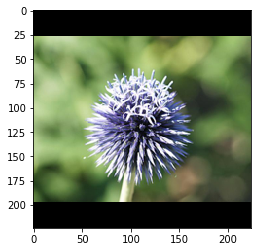

In [14]:
image = Image.open(r"./flowers/valid/10/image_07107.jpg")
mynparr = process_image(image)
imshow(mynparr)

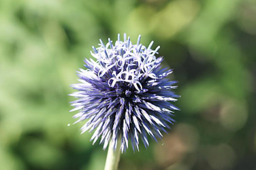

In [15]:
#np_image = np.array(image)
#type(sample[0])
image

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image, model, topk=5):   #(image_path, model, topk=5)
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    
    
    
    return probs, classes
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

49 petunia
(224, 224, 3)
54 bishop of llandaff
(224, 224, 3)
13 balloon flower
(224, 224, 3)
2 blanket flower
(224, 224, 3)
0 49 petunia 49
1 54 bishop of llandaff 54
2 13 balloon flower 13
3 2 blanket flower 2


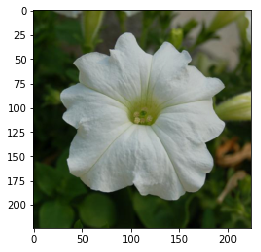

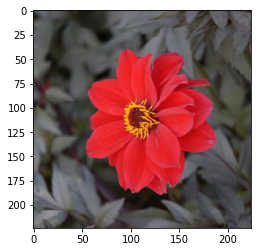

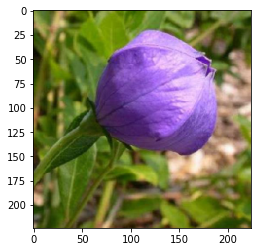

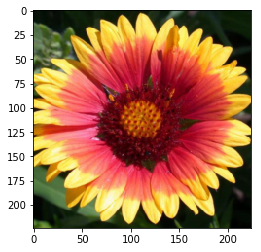

In [17]:
# TODO: Display an image along with the top 5 classes
864

length_of_dataset = len(valid_dataset)

resultdic = dict()
all_images = list()

with torch.no_grad():
    for mycnt in range(4):
        valtens, target = valid_dataset[randint(0, length_of_dataset-1)]
        flowname = cat_to_name.get(valid_dataset.classes[target])
        print(str(target), flowname)
        imshow(valtens)
        #all_images.append(valtens)
        valtens_T = valtens.unsqueeze_(0)
        valtens_T = valtens_T.cuda()
        predicitions = model(valtens_T)
        resultdic[mycnt] = (target, flowname, predicitions.cpu().numpy(), valtens.numpy())
    
for a, b in resultdic.items():
    print(a,b[0],b[1],b[2].argmax()) #cat_to_name.get(b[2].argmax() + 1))
    #imshow(b[3])
    
#imshow(tv.utils.make_grid(all_images))
    
    
#probs, classes = predict(sample, model)  #(image_path, model)


1 pink primrose
0.9984065890312195 pink primrose
0.0015108390944078565 common dandelion
5.714130020351149e-05 wild pansy
2.0732206394313835e-05 cyclamen
2.6667598831409123e-06 prince of wales feathers
8.309958730023936e-07 artichoke
(224, 224, 3)
[9.98406589e-01 1.51083909e-03 5.71413002e-05 2.07322064e-05
 2.66675988e-06 8.30995873e-07]


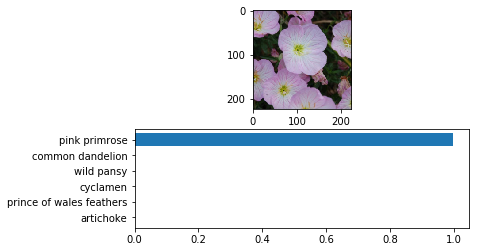

In [18]:
# https://github.com/pytorch/examples/blob/master/imagenet/main.py
#model.eval()
#with torch.no_grad():
#    for valinput, valtarget in dataloader_valid:
#        valinput = valinput.cuda() #non_blocking=True
#        valtarget = valtarget.cuda()
#        print(type(valinput),valinput.size()) #DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! DEBUG!!! 
#        #valoutput = model(valinput)
#        #print(cnt)
        



# https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864
# https://pytorch.org/docs/stable/autograd.html?highlight=variable#variable-deprecated
#from torch.autograd import Variable
with torch.no_grad():
    model.cpu()
    model.eval()
    # 1/image_06758.jpg 1/image_06765.jpg 54/image_05451.jpg 54/image_05406.jpg
    image = Image.open(r"./flowers/valid/1/image_06765.jpg") 
    image_T = valid_transforms(image).float()
    
    image_transformed = torch.tensor(image_T, requires_grad=False)
    #imshow(image_transformed)
    
    image_T = image_T.unsqueeze_(0)
    myoutput = model(image_T)
    catnum = myoutput.data.numpy().argmax() + 1 #Gives the category number
    catname = cat_to_name.get(str(catnum))
   
    
print(catnum, catname)

# http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/
zero_to_one = torch.nn.Softmax(dim=1)

sortval, sortidx = torch.sort(myoutput, descending = True)
sortval = zero_to_one(sortval)
sortval_list = sortval[0].tolist()
sortidx_list = sortidx[0].tolist()
#print(sortval_list)
#print(sortidx_list)
top_vals = list()
top_names = list()
myzip = zip(sortval_list,sortidx_list)
for cnt, sv in enumerate(myzip):
    print(sv[0], cat_to_name.get(str(sv[1]+1)))
    top_vals.append(sv[0])
    top_names.append(cat_to_name.get(str(sv[1]+1)))
    if cnt >= 5:
        break

axs = plt.pyplot.subplot(2,1,1)        
imshow(image_transformed, axs)

plt.pyplot.subplot(2,1,2)
# https://matplotlib.org/gallery/statistics/hist.html
# https://pythonspot.com/matplotlib-bar-chart/
#fig, axs = plt.pyplot.subplots(2, 1)
bc_pos = np.arange(len(top_names))
top_vals = np.asarray(top_vals)
print(top_vals)
plt.pyplot.barh(bc_pos, top_vals)
plt.pyplot.yticks(bc_pos, top_names)
#plt.pyplot.xlabel('Probability')
#plt.pyplot.title('WORK IN PROGRESS')
# https://github.com/plotly/plotly.github.io/issues/110
plt.pyplot.gca().invert_yaxis()

plt.pyplot.show()
        
#print(zeroone(myoutput))#         torch.nn.Softmax().tolist())

#with torch.no_grad():
#    for images, label in dataloader_valid:
#        images, label = images.to('CUDA'), label.to('CUDA')
#        #image.cuda()
#        output = model.forward(images)
#        break
